In [1]:
# MPV17

In [2]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.6.1.dev0


In [3]:
gene_symbol = 'MPV17'
mane_tx_id = 'NM_002437.5'
mane_protein_id = 'NP_002428.1' 

In [5]:
from ppktstore.registry import configure_phenopacket_registry

phenopacket_store_release = '0.1.29'  # Update, if necessary
#registry = configure_phenopacket_registry()

#with registry.open_phenopacket_store(release=phenopacket_store_release) as ps:
#    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
from pyphetools.visualization import PhenopacketIngestor
mpv17_dir = "/Users/robin/GIT/phenopacket-store/notebooks/MPV17/phenopackets"
ingestor = PhenopacketIngestor(indir=mpv17_dir)
ppkt_list = ingestor.get_phenopacket_list()
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

cohort_creator = configure_caching_cohort_creator(hpo)

cohort, qc = load_phenopackets(
    phenopackets=ppkt_list, 
    cohort_creator=cohort_creator,
)
print(f'Loaded {len(cohort)} individuals')
qc.summarize()

[pyphetools] Ingested 60 GA4GH phenopackets.
Individuals Processed: 100%|██████████| 60/60 [00:46<00:00,  1.28individuals/s]
Loaded 60 individuals
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #0
    diseases
      #0
       warnings:

  patient #1
    diseases
      #0
       warnings:

  patient #3
    phenotype-features
      #0
       warnings:

  patient #7
    diseases
      #0
       warnings:

  patient #11
    diseases
      #0
       warnings:

  patient #16
    diseases
      #0
       warnings:

  patient #18
    diseases
      #0
       warnings:

  patient #24
    phenotype-features
      #7
       warnings:

    diseases
      #0
       warnings:

  patient #26
    diseases
      #0
       warnings:

  patient #31
    phenotype-features
      #0
       warnings:

      #1
       warnings:

      #2
       warnings:

      #3
       warnings:

      #4
       warnings:

      #5
       warnings:

      #6
       warnings:

      #7
 

In [6]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Hepatic failure,HP:0001399,34
Increased circulating lactate concentration,HP:0002151,29
Hypoglycemia,HP:0001943,25
Hepatomegaly,HP:0002240,24
Failure to thrive,HP:0001508,23
Elevated circulating alanine aminotransferase concentration,HP:0031964,21
Elevated circulating aspartate aminotransferase concentration,HP:0031956,21
Hypotonia,HP:0001252,21
Global developmental delay,HP:0001263,19
Hepatic steatosis,HP:0001397,16


<Axes: title={'center': 'Protein Mpv17\ntranscript: NM_002437.5, protein: NP_002428.1'}>

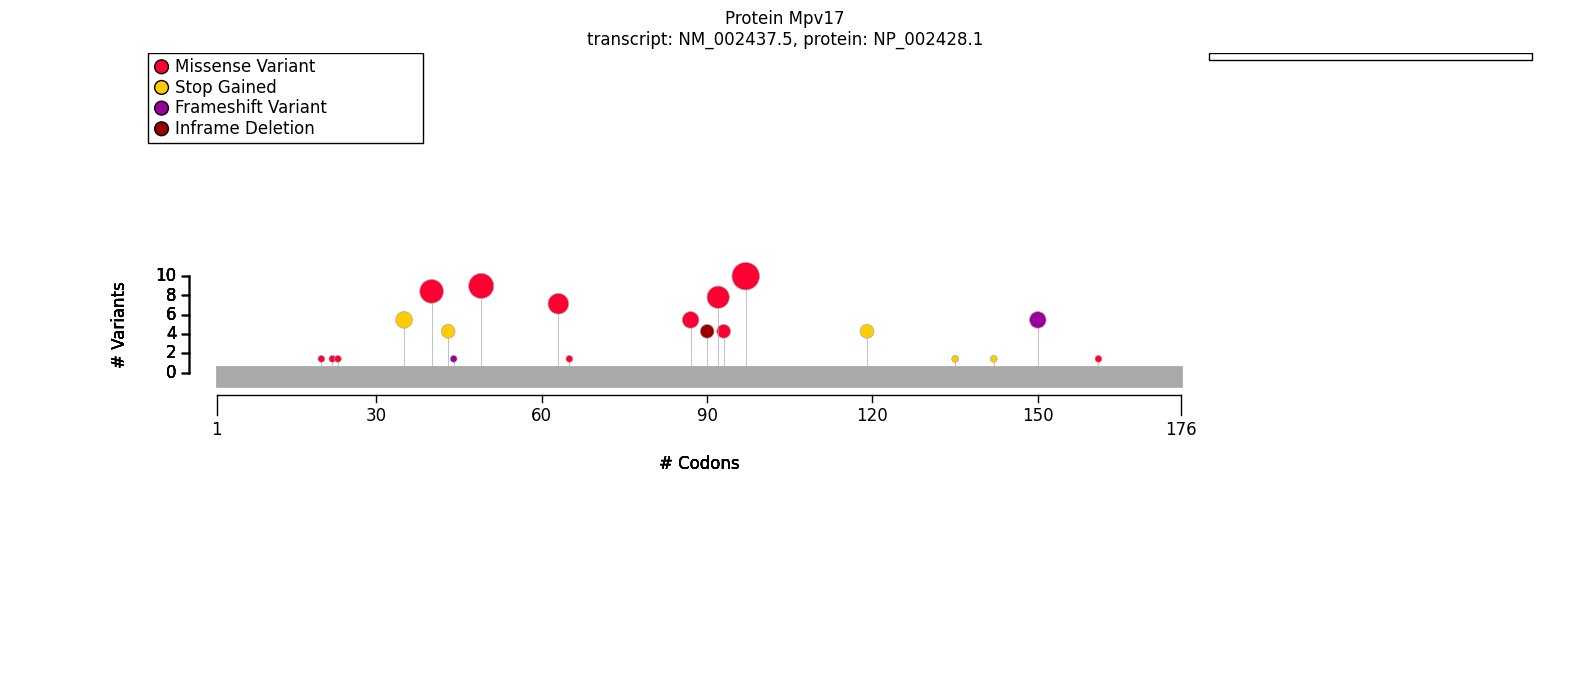

In [9]:
from gpsea.model.genome import GRCh38
from gpsea.preprocessing import VVMultiCoordinateService, configure_default_protein_metadata_service
from gpsea.model import ProteinMetadata

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id) 
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
#protein_meta = ProteinMetadata.from_uniprot_json(uniprot_json="P02461.json", label="Collagen alpha-1(III) chain", protein_length=1466, protein_id=mane_protein_id)


from gpsea.view import ProteinVisualizable, ProteinVisualizer

pvis = ProteinVisualizable(tx_coordinates=tx_coordinates, protein_meta=protein_meta, cohort=cohort)
drawer = ProteinVisualizer()
drawer.draw_fig(pvis=pvis)

In [8]:
from gpsea.view import ProteinVariantViewer
from gpsea.preprocessing import configure_default_protein_metadata_service
pms = configure_default_protein_metadata_service()
protein_meta = pms.annotate(mane_protein_id)
cpd_viewer = ProteinVariantViewer(tx_id=mane_tx_id, protein_metadata=protein_meta)
cpd_viewer.process(cohort=cohort)

Name,Type,Coordinates,Count,Variants


In [10]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Variant key,Variant (cDNA),Variant (protein),Overlapping Exons,Effects,Count
2_27312576_27312576_G_A,c.293C>T,p.Pro98Leu,5,missense,10
2_27313031_27313031_C_T,c.149G>A,p.Arg50Gln,3,missense,8
2_27312681_27312681_T_G,c.278A>C,p.Gln93Pro,4,"missense, splice region",5
2_27312768_27312768_G_C,c.191C>G,p.Pro64Arg,4,missense,5
2_27313059_27313059_G_A,c.121C>T,p.Arg41Trp,3,missense,5
SO:1000029_HGNC:7224_MPV17,SV involving MPV17,p.?,,chromosomal deletion,4
2_27311908_27311908_A_AG,c.451dup,p.Leu151ProfsTer39,7,frameshift,3
2_27313074_27313074_G_A,c.106C>T,p.Gln36Ter,3,stop gained,2
2_27311898_27311898_C_G,c.461+1G>C,None,None,splice donor,2
2_27312510_27312510_C_T,c.359G>A,p.Trp120Ter,5,stop gained,2


In [12]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)
len(pheno_predicates)
from gpsea.analysis.mtc_filter import HpoMtcFilter
mtc_filter = HpoMtcFilter.default_filter( hpo=hpo)
mtc_correction = 'fdr_bh'
mtc_alpha = 0.05
from gpsea.analysis.pcats.stats import FisherExactTest

count_statistic = FisherExactTest()
from gpsea.analysis.pcats import HpoTermAnalysis

analysis = HpoTermAnalysis(
    count_statistic=count_statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
     mtc_alpha=mtc_alpha,
)

In [13]:
from gpsea.model import VariantEffect
from gpsea.analysis.predicate.genotype import VariantPredicates, biallelic_predicate

missense = VariantPredicates.variant_effect(VariantEffect.MISSENSE_VARIANT, tx_id=mane_tx_id)


gt_predicate = biallelic_predicate(a_predicate=missense, 
                                   b_predicate=~missense, 
                                   a_label="missense",
                                   b_label="other",
                                    partitions=((0,1),(2,))
                                   )
print(gt_predicate.display_question())
result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(result)

Allele group: missense/missense OR missense/other, other/other


Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,42
HMF03,Skipping term because of a child term with the same individual counts,1
HMF08,Skipping general term,106
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,235


In [14]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=result)

Allele group                                       missense/missense OR missense/other  \
                                                                                 Count   
Global developmental delay [HP:0001263]                                           9/30   
Hypoglycemia [HP:0001943]                                                        13/29   
Failure to thrive [HP:0001508]                                                   11/24   
Hepatomegaly [HP:0002240]                                                        15/25   
Peripheral neuropathy [HP:0009830]                                               14/27   
Elevated circulating alanine aminotransferase c...                               11/14   
Elevated circulating aspartate aminotransferase...                               11/14   
Hepatic failure [HP:0001399]                                                     22/30   
Prolonged prothrombin time [HP:0008151]                                           6/17   
Jaundice [HP:0000952]                                                             6/13   
Abnormal prothrombin time [HP:0032199]                                            6/15   
Hypotonia [HP:0001252]                                                           17/26   
Abnormal liver morphology [HP:0410042]                                           30/30   
Decreased liver function [HP:0001410]                                            22/22   
Increased circulating lactate concentration [HP...                               18/25   
Acidosis [HP:0001941]                                                            21/21   
Abnormal blood glucose concentration [HP:0011015]                                13/13   
Cholestasis [HP:0001396]                                                         16/16   
Abnormality of the biliary system [HP:0004297]                                   17/17   
Abnormal muscle tone [HP:0003808]                                                17/17   
Visceromegaly [HP:0003271]                                                       15/15   
Hepatic steatosis [HP:0001397]                                                   14/19   
Vomiting [HP:0002013]                                                             7/16   

Allele group                                               other/other  \
                                                   Percent       Count   
Global developmental delay [HP:0001263]                30%       10/14   
Hypoglycemia [HP:0001943]                              45%       12/16   
Failure to thrive [HP:0001508]                         46%       12/16   
Hepatomegaly [HP:0002240]                              60%        9/10   
Peripheral neuropathy [HP:0009830]                     52%        2/10   
Elevated circulating alanine aminotransferase c...     79%       10/10   
Elevated circulating aspartate aminotransferase...     79%       10/10   
Hepatic failure [HP:0001399]                           73%       13/15   
Prolonged prothrombin time [HP:0008151]                35%        7/13   
Jaundice [HP:0000952]                                  46%        7/12   
Abnormal prothrombin time [HP:0032199]                 40%        7/13   
Hypotonia [HP:0001252]                                 65%       10/13   
Abnormal liver morphology [HP:0410042]                100%       14/14   
Decreased liver function [HP:0001410]                 100%       13/13   
Increased circulating lactate concentration [HP...     72%       11/15   
Acidosis [HP:0001941]                                 100%       12/12   
Abnormal blood glucose concentration [HP:0011015]     100%       12/12   
Cholestasis [HP:0001396]                              100%       11/11   
Abnormality of the biliary system [HP:0004297]        100%       11/11   
Abnormal muscle tone [HP:0003808]                     100%       10/10   
Visceromegaly [HP:0003271]                            100%         9/9   
Hepatic steatosis [HP:0001397]                 